In [2]:
import sympy as sm
from sympy import diff, Symbol, cos
from scipy.integrate import solve_ivp,OdeSolver,odeint
import numpy as np
from sympy.physics.mechanics import dynamicsymbols
import math
import matplotlib.pyplot as plt

In [3]:
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex="mathjax", pretty_print=False)

In [4]:
m1, m2, l1, l2, gty ,tau1, tau2, c1, c2, L, I1, I2 = sm.symbols('m1 m2 l1 l2 g tau1 tau2 c1 c2 L I1 I2', real =True)
t = Symbol('t')
theta1, theta2 = dynamicsymbols('theta1 theta2')
theta1d = dynamicsymbols('theta1',1)
theta2d = dynamicsymbols('theta2',1)
theta1dd = dynamicsymbols('theta1',2)
theta2dd = dynamicsymbols('theta2',2)
gty, m1, m2, l1, l2, theta1, theta2, theta1d, theta2d, theta1dd, theta2dd, tau1, tau2,I1, I2

(g, m1, m2, l1, l2, theta1, theta2, theta1', theta2', theta1'', theta2'', tau1, tau2, I1, I2)

In [5]:
x1 = l1*sm.cos(theta1)
y1 = l1*sm.sin(theta1)
x2 = l1*sm.cos(theta1) + l2*sm.cos(theta2)
y2 = l1*sm.sin(theta1) + l2*sm.sin(theta2)

x1_dot = sm.diff(x1,t)
x2_dot = sm.diff(x2,t)
y1_dot = sm.diff(y1,t)
y2_dot = sm.diff(y2,t)

x1_dot , x2_dot, y1_dot , y2_dot

(-l1*sin(theta1)*theta1', -l1*sin(theta1)*theta1' - l2*sin(theta2)*theta2', l1*cos(theta1)*theta1', l1*cos(theta1)*theta1' + l2*cos(theta2)*theta2')

# dynamic modeling on manipulator without constraint using lagrange equation

In [6]:
# kinetic energy
ke = (sm.Rational(1/2))*m1*(x1_dot**2)
ke += (sm.Rational(1/2))*m1*(y1_dot**2)
ke += (sm.Rational(1/2))*m2*(x2_dot**2)
ke += (sm.Rational(1/2))*m2*(y2_dot**2)
sm.simplify(ke)

l1**2*m1*theta1'**2/2 + l1**2*m2*theta1'**2/2 + l1*l2*m2*cos(theta1 - theta2)*theta1'*theta2' + l2**2*m2*theta2'**2/2

In [7]:
# potential energy
pe = m1*gty*y1
pe += m2*gty*y2
sm.expand(pe)

g*l1*m1*sin(theta1) + g*l1*m2*sin(theta1) + g*l2*m2*sin(theta2)

In [8]:
# the lagrangian equation
Ls = ke - pe

In [9]:
# force applied at joint 1
f1 = sm.diff(sm.diff(Ls,theta1d),t) - sm.diff(Ls,theta1)
f1sim = sm.expand(sm.simplify(f1))
f1sim

g*l1*m1*cos(theta1) + g*l1*m2*cos(theta1) + l1**2*m1*theta1'' + l1**2*m2*theta1'' + l1*l2*m2*sin(theta1 - theta2)*theta2'**2 + l1*l2*m2*cos(theta1 - theta2)*theta2''

In [10]:
# force applied at joint 2
f2 = sm.diff(sm.diff(Ls,theta2d),t) - sm.diff(Ls,theta2)
f2sim = sm.expand(sm.simplify(f2))
f2sim

g*l2*m2*cos(theta2) - l1*l2*m2*sin(theta1 - theta2)*theta1'**2 + l1*l2*m2*cos(theta1 - theta2)*theta1'' + l2**2*m2*theta2''

In [11]:
#inertia term
it11 = f1sim.coeff(theta1dd) * theta1dd
it12 = f2sim.coeff(theta1dd) * theta1dd

it21 = f1sim.coeff(theta2dd) * theta2dd
it22 = f2sim.coeff(theta2dd) * theta2dd

m11 = f1sim.coeff(theta1dd)
m12 = f2sim.coeff(theta1dd)

m21 = f1sim.coeff(theta2dd)
m22 = f2sim.coeff(theta2dd)

M = sm.Matrix([[m11, m21], [m12, m22]])
M

Matrix([
[          l1**2*m1 + l1**2*m2, l1*l2*m2*cos(theta1 - theta2)],
[l1*l2*m2*cos(theta1 - theta2),                      l2**2*m2]])

In [12]:
#centrifugal / Coriolis force term,
C11 = (f1sim.coeff(theta1d * theta2d)*theta1d * theta2d) + (f1sim.coeff(theta1d * theta1d)* theta1d * theta1d) + (f1sim.coeff(theta2d * theta2d)*theta2d * theta2d)
C12 = (f2sim.coeff(theta1d * theta2d)*theta1d * theta2d) + (f2sim.coeff(theta1d * theta1d)* theta1d * theta1d) + (f2sim.coeff(theta2d * theta2d)*theta2d * theta2d)

C = sm.Matrix([[C11], [C12]])
C

Matrix([
[ l1*l2*m2*sin(theta1 - theta2)*theta2'**2],
[-l1*l2*m2*sin(theta1 - theta2)*theta1'**2]])

In [13]:
# gravity term
g1 = f1sim - sm.expand(it11) - sm.expand(it21) - sm.expand(C11)
g2 = f2sim - sm.expand(it12) - sm.expand(it22) - sm.expand(C12)
G = sm.Matrix([g1, g2])
G

Matrix([
[g*l1*m1*cos(theta1) + g*l1*m2*cos(theta1)],
[                      g*l2*m2*cos(theta2)]])

In [14]:
tau = sm.Matrix([[tau1], [tau2]])
tau

Matrix([
[tau1],
[tau2]])

In [27]:
d = (sm.Matrix([[c1,0],[0,c2]]) * sm.Matrix([theta1d, theta2d]))
d

Matrix([
[c1*theta1'],
[c2*theta2']])

In [28]:
F = tau -C -G + d
F

Matrix([
[c1*theta1' - g*l1*m1*cos(theta1) - g*l1*m2*cos(theta1) - l1*l2*m2*sin(theta1 - theta2)*theta2'**2 + tau1],
[                      c2*theta2' - g*l2*m2*cos(theta2) + l1*l2*m2*sin(theta1 - theta2)*theta1'**2 + tau2]])

# Dynamic modeling subject to constraint

In [15]:
endefX = x2 - L #endeffector x trajectory
endefY = y2 - 0.2*(1-sm.cos(t)) #endeffector y trajectory
endefX, endefY

(-L + l1*cos(theta1) + l2*cos(theta2), l1*sin(theta1) + l2*sin(theta2) + 0.2*cos(t) - 0.2)

In [16]:
# get second order form
endefXdd = sm.diff(sm.diff(endefX,t),t)
endefYdd = sm.diff(sm.diff(endefY,t),t)
endefXdd, endefYdd

(-l1*sin(theta1)*theta1'' - l1*cos(theta1)*theta1'**2 - l2*sin(theta2)*theta2'' - l2*cos(theta2)*theta2'**2, -l1*sin(theta1)*theta1'**2 + l1*cos(theta1)*theta1'' - l2*sin(theta2)*theta2'**2 + l2*cos(theta2)*theta2'' - 0.2*cos(t))

In [17]:
A11 = endefXdd.coeff(theta1dd)
A21 = endefXdd.coeff(theta2dd)

A12 = endefYdd.coeff(theta1dd)
A22 = endefYdd.coeff(theta2dd)

A = sm.Matrix([[A11, A21], [A12, A22]])
A

Matrix([
[-l1*sin(theta1), -l2*sin(theta2)],
[ l1*cos(theta1),  l2*cos(theta2)]])

In [18]:
b1 = endefXdd - sm.expand(A11)*theta1dd - sm.expand(A21)*theta2dd
b2 = endefYdd - sm.expand(A12)*theta1dd - sm.expand(A22)*theta2dd
b = -sm.Matrix([b1,b2])
b

Matrix([
[             l1*cos(theta1)*theta1'**2 + l2*cos(theta2)*theta2'**2],
[l1*sin(theta1)*theta1'**2 + l2*sin(theta2)*theta2'**2 + 0.2*cos(t)]])

# solve system

In [19]:
# ode func for scipy solve_ivp
theta1d_func = sm.lambdify(theta1d, theta1d)
theta2d_func = sm.lambdify(theta2d, theta2d)

t_span = (0, 100)
g_ = 0
m1_ = 1
m2_ = 1
l1_ = 1
l2_ = 1
tq1_ = 0
tq2_ = 0
c1_ = 0.5
c2_ = 0.5
y0 = [30,0,-30,0]  # Initial state of the system


In [34]:
h_sn = (A*(M**(-1/2))).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
j_sn = (M**(1/2)).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
k_sn = (b-(A*(M.inv()*F))).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
F_sn = F.subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
M_sn = M.subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})

In [35]:
def dSdt(t,S, gt, m1, m2, l1, l2,c1, c2, torq1, torq2):
    thet1_, dtheta1_, thet2_, dtheta2_ = S
    
    print(t, S)
    
    h_n = h_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    j_n = j_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    k_n = k_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    psu_i = h_n.pinv()
    Fc = (j_n * psu_i * k_n)
    F_n = F_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    rf = F_n + Fc
    ra = M_sn.inv().subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf() * rf
    return [
        theta1d_func(dtheta1_),
        ra[0],
        theta2d_func(dtheta2_),
        ra[1]
    ]

In [36]:
solve_ivp_rk45 = solve_ivp(dSdt,t_span, y0, method="LSODA", args = (g_,m1_,m2_,l1_,l2_,c1_,c2_,tq1_,tq2_))

0.0 [ 30.   0. -30.   0.]
4.8778591397005856e-05 [ 3.00000000e+01  3.16227766e-05 -3.00000000e+01  3.16227766e-05]
4.8778591397005856e-05 [ 3.00000000e+01  3.16227766e-05 -3.00000000e+01  3.16227766e-05]
9.755718279401171e-05 [ 3.00000000e+01  6.32455532e-05 -3.00000000e+01  6.32455531e-05]
9.755718279401171e-05 [ 3.00000000e+01  6.32455531e-05 -3.00000000e+01  6.32455529e-05]
0.00028692353341082367 [ 3.00000000e+01  1.86010266e-04 -3.00000000e+01  1.86010265e-04]
0.00028692353341082367 [ 3.00000000e+01  1.86010265e-04 -3.00000000e+01  1.86010263e-04]
0.0004762898840276356 [ 3.00000001e+01  3.08774973e-04 -2.99999999e+01  3.08774967e-04]
0.0004762898840276356 [ 3.00000001e+01  3.08774972e-04 -2.99999999e+01  3.08774964e-04]
0.0006656562346444476 [ 3.00000001e+01  4.31539672e-04 -2.99999999e+01  4.31539654e-04]
0.0006656562346444476 [ 3.00000001e+01  4.31539671e-04 -2.99999999e+01  4.31539651e-04]
0.0008550225852612596 [ 3.00000002e+01  5.54304361e-04 -2.99999998e+01  5.54304320e-04]
0.

2.2732543628373523 [ 30.89190676   0.28969082 -29.25307238   0.17531837]
2.4274036410933175 [ 30.93274883   0.23575545 -29.2288996    0.13421433]
2.5815529193492828 [ 30.96520078   0.18354368 -29.21080511   0.09916017]
2.5503358096777555 [ 30.95916617   0.19422329 -29.21417471   0.10614169]
2.6732679782621935 [ 30.9804447    0.1533427  -29.20278285   0.08099465]
2.7962001468466315 [ 30.99673515   0.11291705 -29.19434021   0.05808075]
2.9191323154310695 [ 31.00814773   0.07283101 -29.18852368   0.03681749]
3.0420644840155076 [ 3.10146692e+01  3.29631310e-02 -2.91852208e+01  1.66456404e-02]
3.235462359270212 [ 3.10150266e+01 -2.95853762e-02 -2.91849499e+01 -1.43048665e-02]
3.235462359270212 [ 3.10150270e+01 -2.95853762e-02 -2.91849499e+01 -1.43048665e-02]
3.235462359270212 [ 3.10150266e+01 -2.95853758e-02 -2.91849499e+01 -1.43048665e-02]
3.235462359270212 [ 3.10150266e+01 -2.95853762e-02 -2.91849494e+01 -1.43048665e-02]
3.235462359270212 [ 3.10150266e+01 -2.95853762e-02 -2.91849499e+01 -

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


KeyboardInterrupt: 

In [23]:
t = solve_ivp_rk45.t
the1 = solve_ivp_rk45.y[0]
the1d = solve_ivp_rk45.y[1]
the2 = solve_ivp_rk45.y[2]
the2d = solve_ivp_rk45.y[3]

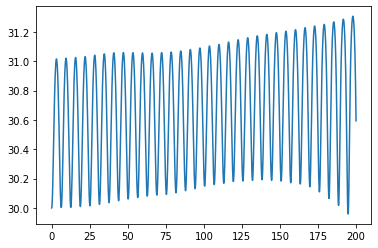

In [24]:
plt.plot(t, the1, label=f'$X_{0}(t)$')

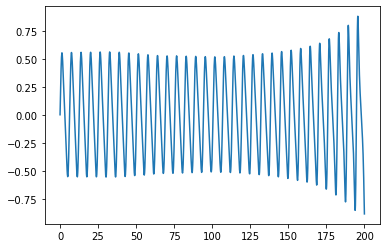

In [25]:
plt.plot(t, the1d, label=f'$X_{1}(t)$')

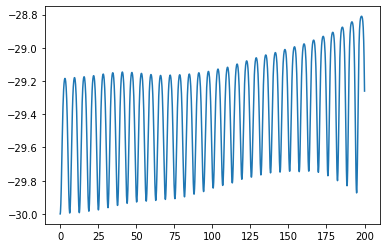

In [26]:
plt.plot(t, the2, label=f'$X_{2}(t)$')

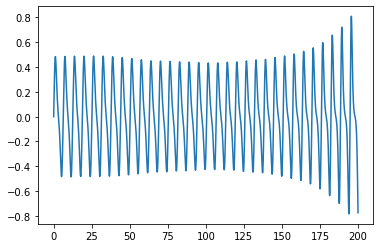

In [27]:
plt.plot(t, the2d, label=f'$X_{3}(t)$')